<img src="../Fink_PrimaryLogo_WEB.jpg" width=400 />

# Fink case study: Galactic Science

## Goal

This notebook shows how to explore the alerts associated to galactic events in the Fink database. We show-case two science cases: variable stars & gravitational microlensing events.

## What is behind?

Each night, Fink cross-matches in real-time alerts from the ZTF public stream with the CDS SIMBAD database (galactic and extragalactic) using the [CDS xmatch service](http://cdsxmatch.u-strasbg.fr/xmatch). Up to 30% of the alerts that survive quality cuts ends up with a counter-part in the  [SIMBAD (Wenger et al. 2020)](https://aas.aanda.org/articles/aas/abs/2000/07/ds1821/ds1821.html) database. Concerning galactic classes, the most frequent are Variable Star of RR Lyr type (`RRLyr`) and Eclipsing binary (`EB*`). On the other hand, we also have a module to detect microlensing events, based on `Lensed Identification Algorithm` ([LIA](https://github.com/dgodinez77/LIA)). 

## Useful links

- API documentation: http://134.158.75.151:24000/api
- Schema of Fink database: http://134.158.75.151:24000/api/v1/columns
- CDS xmatch service: http://cdsxmatch.u-strasbg.fr/xmatch
- SIMBAD description of classes: http://simbad.u-strasbg.fr/simbad/sim-display?data=otypes
- LIA: https://github.com/dgodinez77/LIA

## Environment set up

To run this notebook, you need to import the following libraries (some are already installed in  colab):

In [1]:
!pip install gatspy
!pip install seaborn
!pip install fink_science

import requests

import pandas as pd
import numpy as np

from fink_science.conversion import dc_mag
from gatspy import periodic

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

     |████████████████████████████████| 554 kB 2.6 MB/s eta 0:00:01
Using legacy 'setup.py install' for gatspy, since package 'wheel' is not installed.
    Running setup.py install for gatspy ... done
     |████████████████████████████████| 8.6 MB 2.4 MB/s eta 0:00:01


## Case study 1: Variable stars in our galaxy

### Association criterion and nightly rate 

Fink cross-matches in real-time alerts from the ZTF public stream with the CDS SIMBAD database (galactic and extragalactic) using the [CDS xmatch service](http://cdsxmatch.u-strasbg.fr/xmatch). Up to 30% of the alerts that survive quality cuts ends up with a counter-part in the SIMBAD database. Concerning galactic classes, the most present are Variable Star of RR Lyr type (`RRLyr`), Eclipsing binary (`EB*`), Long-period variable star (`LPV*`), Variable Star of Mira Cet type (`Mira`). The way we associate alerts to known SIMBAD objects is based on the spatial position only: if the alert is within 1 arcsecond of a known SIMBAD object, they are associated. In case of several objects within a radius of 1 arcsecond, we take the closest one.

### Querying the Fink database by class

Fink has a service to query objects by their class. The list of arguments for getting latest alerts by class can be found at http://134.158.75.151:24000/api/v1/latests, and the available classes can be found at http://134.158.75.151:24000/api/v1/classes. We will focus on classes taken from SIMBAD association, starting with `(SIMBAD)`.


#### Example: search for RRLyr

In [2]:
# Get latests 100 alerts associated to RRLyr
r = requests.post(
  'http://134.158.75.151:24000/api/v1/latests',
  json={
    'class': '(SIMBAD) RRLyr',
    'n': '100',
  }
)

# Format output in a DataFrame
pdf_rrlyr = pd.read_json(r.content)

You will get a pandas DataFrame containing, whose rows are alerts from the Fink database that are associated to the class `(SIMBAD) RRLyr`. We recall that the DataFrame column schema can be read from http://134.158.75.151:24000/api/v1/columns. In the Fink Web Portal, you would just choose the class from the search bar:

<img src="rrlyr_search.png" width=1000 />

#### Get photometry

The `latests` service will give you latests alerts associated to a particular class, but you will not have the full photometry of each object. For this, you can query the `objects` service using a previously returned `objectId`:

In [3]:
# Get alerts associated with an specific object ID
r = requests.post(
  'http://134.158.75.151:24000/api/v1/objects',
  json={
    'objectId': pdf_rrlyr['i:objectId'].values[0],
    'withupperlim': 'True',
  }
)

# Format output in a DataFrame
pdf_rrlyr_phot = pd.read_json(r.content)

#### Extracting some properties

From the DataFrame, you can easily inspect the lightcurve of the object:

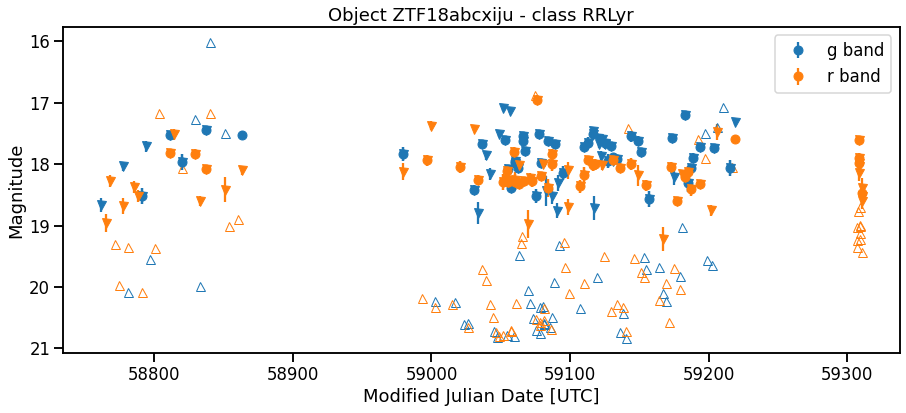

In [6]:
mjd = pdf_rrlyr_phot['i:jd'].apply(lambda x: x - 2400000.5)

fig = plt.figure(figsize=(15, 6))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}

for filt in np.unique(pdf_rrlyr_phot['i:fid']):
    maskFilt = pdf_rrlyr_phot['i:fid'] == filt

    # The column `d:tag` is used to check data type
    maskValid = pdf_rrlyr_phot['d:tag'] == 'valid'
    plt.errorbar(
        pdf_rrlyr_phot[maskValid & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_rrlyr_phot[maskValid & maskFilt]['i:magpsf'],
        pdf_rrlyr_phot[maskValid & maskFilt]['i:sigmapsf'],
        ls = '', marker='o', color=colordic[filt], label='{} band'.format(filtdic[filt])
    )

    maskUpper = pdf_rrlyr_phot['d:tag'] == 'upperlim'
    plt.plot(
        pdf_rrlyr_phot[maskUpper & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_rrlyr_phot[maskUpper & maskFilt]['i:diffmaglim'],
        ls='', marker='^', color=colordic[filt], markerfacecolor='none'
    )

    maskBadquality = pdf_rrlyr_phot['d:tag'] == 'badquality'
    plt.errorbar(
        pdf_rrlyr_phot[maskBadquality & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_rrlyr_phot[maskBadquality & maskFilt]['i:magpsf'],
        pdf_rrlyr_phot[maskBadquality & maskFilt]['i:sigmapsf'],
        ls='', marker='v', color=colordic[filt]
    )

plt.gca().invert_yaxis()
plt.legend()
plt.title(
    'Object {} - class {}'.format(
        pdf_rrlyr_phot['i:objectId'].values[0],
        pdf_rrlyr_phot['d:cdsxmatch'].values[0]
    )
)
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Magnitude')
plt.show()

#### Extracting period

In the Fink Web Portal, we provide tools to fit for the period of an object. The fit is done using [gatspy](https://zenodo.org/record/47887) described in [VanderPlas & Ivezic (2015)](https://ui.adsabs.harvard.edu/abs/2015ApJ...812...18V/abstract). We use a multiband periodogram (LombScargleMultiband) to find the best period. Alternatively, you can manually set the period in days:

<img src="rrlyr_fit.png" width=1000 />

Let's redo this analysis here:

In [7]:
maskValid = pdf_rrlyr_phot['d:tag'] == 'valid'
mag_dc, err_dc = np.transpose(
    [
        dc_mag(*args) for args in zip(
            pdf_rrlyr_phot[maskValid]['i:fid'].astype(int).values,
            pdf_rrlyr_phot[maskValid]['i:magpsf'].astype(float).values,
            pdf_rrlyr_phot[maskValid]['i:sigmapsf'].astype(float).values,
            pdf_rrlyr_phot[maskValid]['i:magnr'].astype(float).values,
            pdf_rrlyr_phot[maskValid]['i:sigmagnr'].astype(float).values,
            pdf_rrlyr_phot[maskValid]['i:magzpsci'].astype(float).values,
            pdf_rrlyr_phot[maskValid]['i:isdiffpos'].values
        )
    ]
)

jd = pdf_rrlyr_phot[maskValid]['i:jd']
model = periodic.LombScargleMultiband(
    Nterms_base=1,
    Nterms_band=1,
    fit_period=True
)

# Not sure about that...
model.optimizer.period_range = (0.1, 1.2)
model.optimizer.quiet = True

model.fit(
    jd.astype(float),
    mag_dc,
    err_dc,
    pdf_rrlyr_phot[maskValid]['i:fid'].astype(int)
)

period = model.best_period
phase = jd.astype(float).values % period
tfit = np.linspace(0, period, 100)

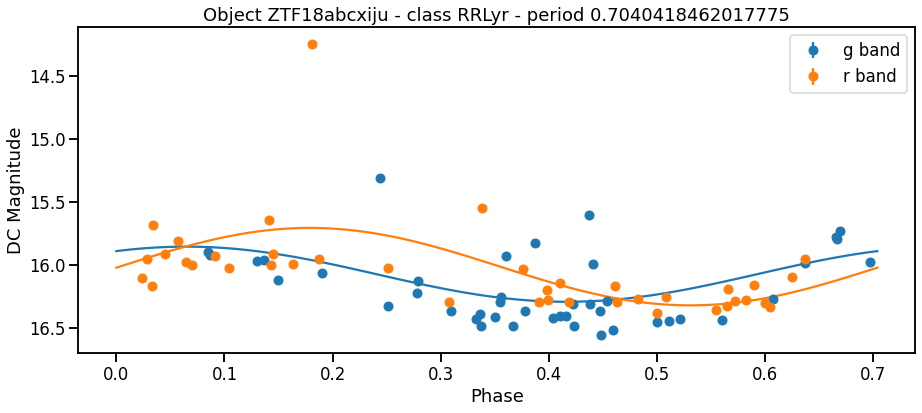

In [8]:
fig = plt.figure(figsize=(15, 6))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}

for filt in np.unique(pdf_rrlyr_phot['i:fid']):
    maskFilt = pdf_rrlyr_phot[maskValid]['i:fid'] == filt
    plt.errorbar(
        phase[maskFilt], 
        mag_dc[maskFilt],
        err_dc[maskFilt],
        ls = '', marker='o', color=colordic[filt], 
        label='{} band'.format(filtdic[filt])
    )
    
    plt.plot(tfit, model.predict(tfit, period=period, filts=filt))

plt.gca().invert_yaxis()
plt.legend()
plt.title(
    'Object {} - class {} - period {}'.format(
        pdf_rrlyr_phot['i:objectId'].values[0],
        pdf_rrlyr_phot['d:cdsxmatch'].values[0],
        period
    )
)
plt.xlabel('Phase')
plt.ylabel('DC Magnitude');
plt.show()

You can actually check the validity of the period fit on [ASAS-SN](https://asas-sn.osu.edu/variables?ra=346.7715507&dec=31.7946076&radius=0.5&vmag_min=&vmag_max=&amplitude_min=&amplitude_max=&period_min=&period_max=&lksl_min=&lksl_max=&class_prob_min=&class_prob_max=&parallax_over_err_min=&parallax_over_err_max=&name=&references[]=I&references[]=II&references[]=III&references[]=IV&references[]=V&references[]=VI&sort_by=raj2000&sort_order=asc&show_non_periodic=true&show_without_class=true&asassn_discov_only=false&).

## Case study 2: Gravitational microlensing 


### Going further



## How to reach us

An issue to report, or a question to ask: contact@fink-broker.org!